In [1]:
print("hello world")

hello world


### prepare datas to use

In [1]:
for month in range(1,13):
    print("https://s3.amazonaws.com/nyc-tlc/trip+data/"+"green_tripdata_2019-{0:0>2d}.csv".format(month))

https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-01.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-02.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-03.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-04.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-05.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-06.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-07.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-08.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-09.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-10.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-11.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-12.csv


### prepare Taxi Zone And Lookup Table (CSV)

### test local file lists

### The following libraries are the basic libraries for data analytics

In [2]:
import pandas as pd
import numpy as np
import urllib.request
import sqlalchemy
import zipfile
import random
import itertools
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### preparing local target db to store data

In [3]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_tlc_green-car_database.db')

In [5]:
conn = nyc_database.connect()
conn

### Test Data Format to check fileds

### A. Analyzing Trip Record Data to see what i need

The green taxi trip records include lots of fields :

+ pick-up and drop-off dates/times but current is not fit for me
+ pick-up and drop-off locations but current is not fit for me
+ RatecodeID
+ PULocationID and DOLocationID
+ trip distances
+ itemized fares
+ rate types
+ payment types
+ total_amount
+ driver-reported passenger counts

i still need at least two more colums to use dates/times without years

In [13]:
# df = pd.read_csv("green_tripdata_2019-01.csv",usecols=lambda x: x not in [3, 14],nrows=10)
df = pd.read_csv("green_tripdata_2019-01.csv",usecols=[0,1,2,4,5,6,7,8,9,10,11,12,13,15,16,17,18],nrows=10)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-12-21 15:17:29,2018-12-21 15:18:57,1,264,264,5,0.00,3.0,0.5,0.5,0.00,0,0.3,4.30,2,1
1,2,2019-01-01 00:10:16,2019-01-01 00:16:32,1,97,49,2,0.86,6.0,0.5,0.5,0.00,0,0.3,7.30,2,1
2,2,2019-01-01 00:27:11,2019-01-01 00:31:38,1,49,189,2,0.66,4.5,0.5,0.5,0.00,0,0.3,5.80,1,1
3,2,2019-01-01 00:46:20,2019-01-01 01:04:54,1,189,17,2,2.68,13.5,0.5,0.5,2.96,0,0.3,19.71,1,1
4,2,2019-01-01 00:19:06,2019-01-01 00:39:43,1,82,258,1,4.53,18.0,0.5,0.5,0.00,0,0.3,19.30,2,1


#### extract data and skip some colums 
+ 'store_and_fwd_flag'/3,
+ 'ehail_fee'/14,
+ 'congestion_surcharge'/19

In [6]:
def get_lat_lon(sf,shp_dic):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [7]:
sf = shapefile.Reader("shape/taxi_zones.shp")
sf

In [8]:
sf.fields[1:]

[['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

In [10]:
fields_name = [field[0] for field in sf.fields[1:]]
fields_name

['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough']

In [ ]:
attributes = sf.records()
attributes

In [13]:
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
shp_dic

{'OBJECTID': 0,
 'Shape_Leng': 1,
 'Shape_Area': 2,
 'zone': 3,
 'LocationID': 4,
 'borough': 5}

In [ ]:
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]
shp_attr

In [14]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf,shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [15]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [17]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [18]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

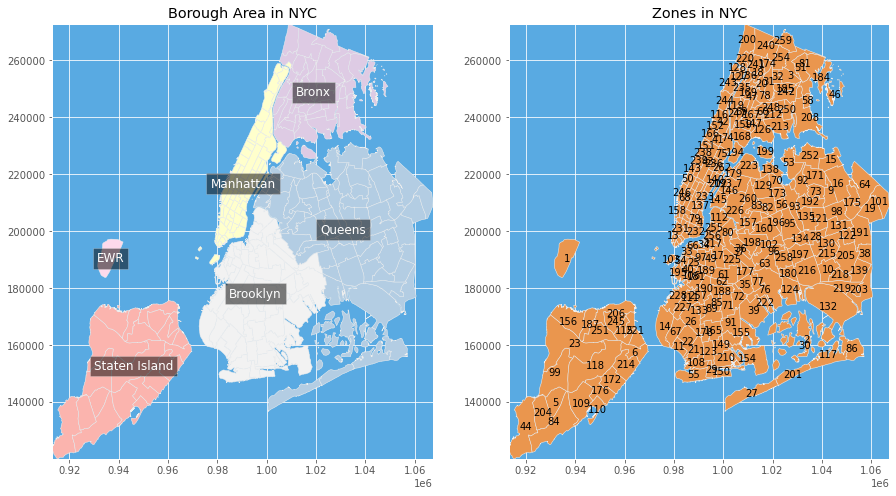

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Borough Area in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

### Q1: Which regions have most pickups and drop-offs?

In [22]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_database)

In [23]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])

In [28]:
template.head()

,LocationID
0,1
1,2
2,3
3,4
4,5


In [24]:
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])

In [27]:
df_q1.head()

,LocationID,PUcount,DOcount
0,1,103.0,1898.0
1,2,33.0,70.0
2,3,5410.0,6048.0
3,4,220.0,6054.0
4,5,63.0,128.0


In [29]:
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']

In [30]:
df_q1.head()

,LocationID,PUcount,DOcount,TOTALcount
0,1,103.0,1898.0,2001.0
1,2,33.0,70.0,103.0
2,3,5410.0,6048.0,11458.0
3,4,220.0,6054.0,6274.0
4,5,63.0,128.0,191.0


In [31]:
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")


In [32]:
loc.head()

,LocationID,zone,borough
0,1,Newark Airport,EWR
1,2,Jamaica Bay,Queens
2,3,Allerton/Pelham Gardens,Bronx
3,4,Alphabet City,Manhattan
4,5,Arden Heights,Staten Island


In [33]:
df_q1.head()

,LocationID,PUcount,DOcount,TOTALcount,zone,borough
0,1,103.0,1898.0,2001.0,Newark Airport,EWR
1,2,33.0,70.0,103.0,Jamaica Bay,Queens
2,3,5410.0,6048.0,11458.0,Allerton/Pelham Gardens,Bronx
3,4,220.0,6054.0,6274.0,Alphabet City,Manhattan
4,5,63.0,128.0,191.0,Arden Heights,Staten Island


In [31]:
PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)

In [32]:
PUtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
74,462004.0,225204.0,687208.0,East Harlem North,Manhattan
75,371439.0,161401.0,532840.0,East Harlem South,Manhattan
41,336712.0,186725.0,523437.0,Central Harlem,Manhattan


In [33]:
DOtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
74,462004.0,225204.0,687208.0,East Harlem North,Manhattan
42,203629.0,209341.0,412970.0,Central Harlem North,Manhattan
41,336712.0,186725.0,523437.0,Central Harlem,Manhattan


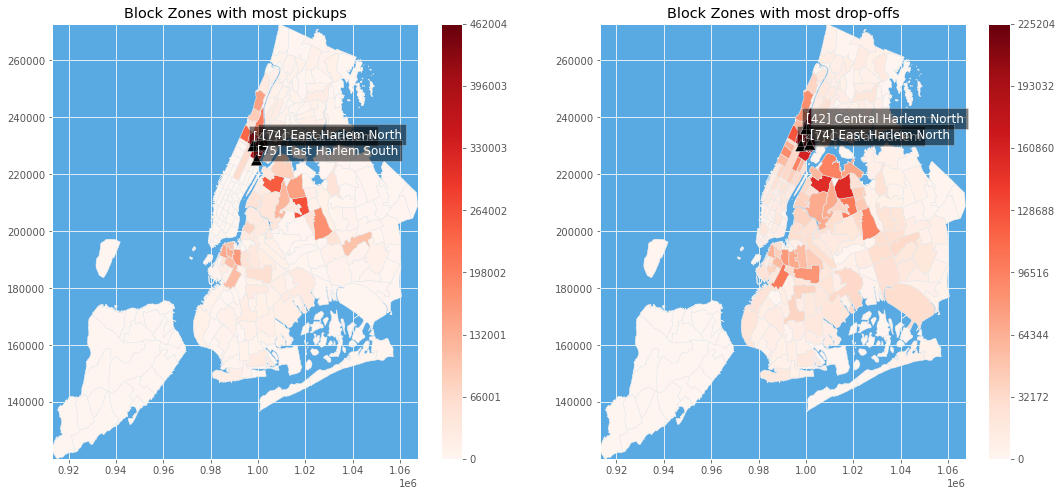

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Block Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Block Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

In [35]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
df_q1_region

,borough,PUcount,DOcount,TOTALcount
3,Manhattan,2067691.0,2269475.0,4337166.0
4,Queens,1790139.0,1828324.0,3618463.0
1,Brooklyn,1687247.0,1451394.0,3138641.0
0,Bronx,407090.0,467935.0,875025.0
5,Staten Island,2840.0,4149.0,6989.0
2,EWR,103.0,1898.0,2001.0


In [36]:
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

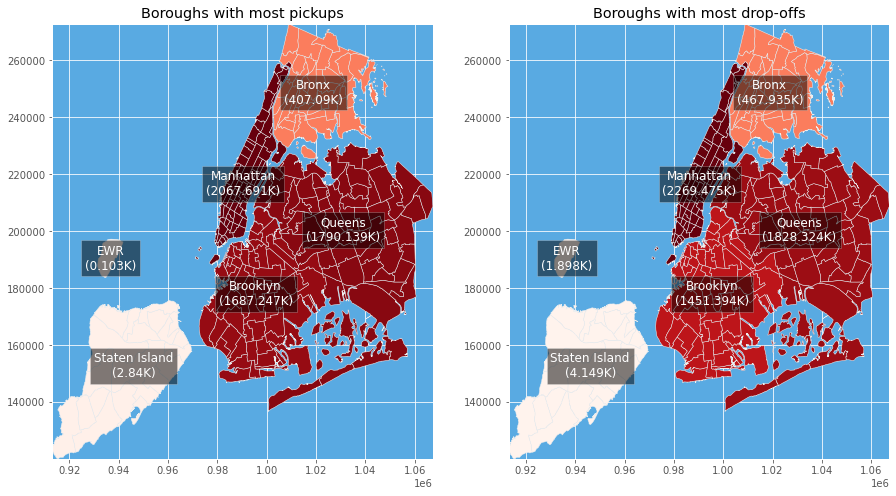

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

##### obviously most-pick and most drop-off is manhattan

### Q2: When are the peak hours and off-peak hours for taking taxi?

In [39]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

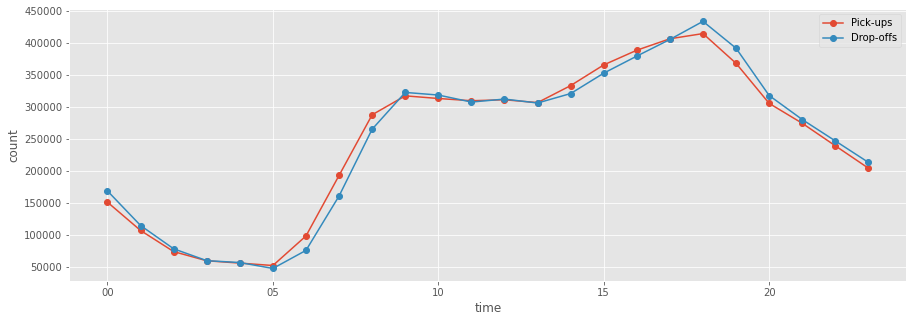

In [41]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()

#### Q3: What are the differences between short and long distance trips of taking taxi?

In [45]:
# avoid distance less than 0
df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record WHERE trip_distance > 0', nyc_database)
df_dist['trip_distance'].describe()

count    5.779493e+06
mean     3.364741e+00
std      3.957037e+00
min      1.000000e-02
25%      1.100000e+00
50%      2.000000e+00
75%      3.950000e+00
max      6.666000e+02
Name: trip_distance, dtype: float64

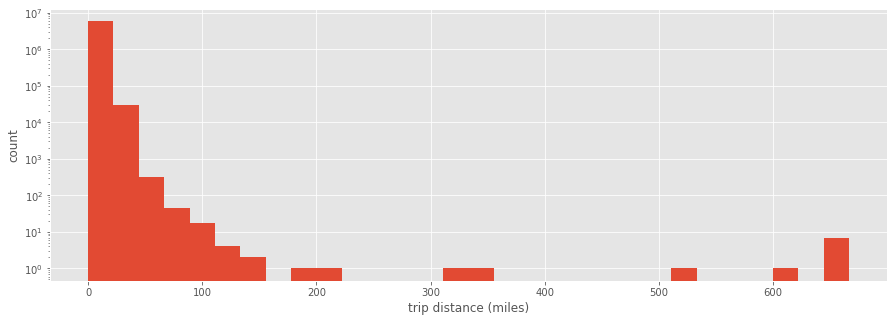

In [46]:
ax = df_dist['trip_distance'].hist(bins=30, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

In [47]:
df_q3_short = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                 WHERE trip_distance < 30 and trip_distance > 0', nyc_database)
df_q3_long = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                WHERE trip_distance >= 30 ', nyc_database)
print("Short Trips: {} records in total.\nLong Trips: {} records in total."\
     .format(df_q3_short.values[0][0], df_q3_long.values[0][0]))

Short Trips: 5775275 records in total.
Long Trips: 4218 records in total.


In [49]:
df_q3_short = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                 WHERE trip_distance < 30', nyc_database)
df_q3_long = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                WHERE trip_distance >= 30 ', nyc_database)
print("Short Trips: {} records in total.\nLong Trips: {} records in total."\
     .format(df_q3_short.values[0][0], df_q3_long.values[0][0]))

Short Trips: 5925840 records in total.
Long Trips: 4218 records in total.


In [50]:
df_q3_short = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)
df_q3_long = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

In [52]:
def diff_short_long_trip_on_time():
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

In [54]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

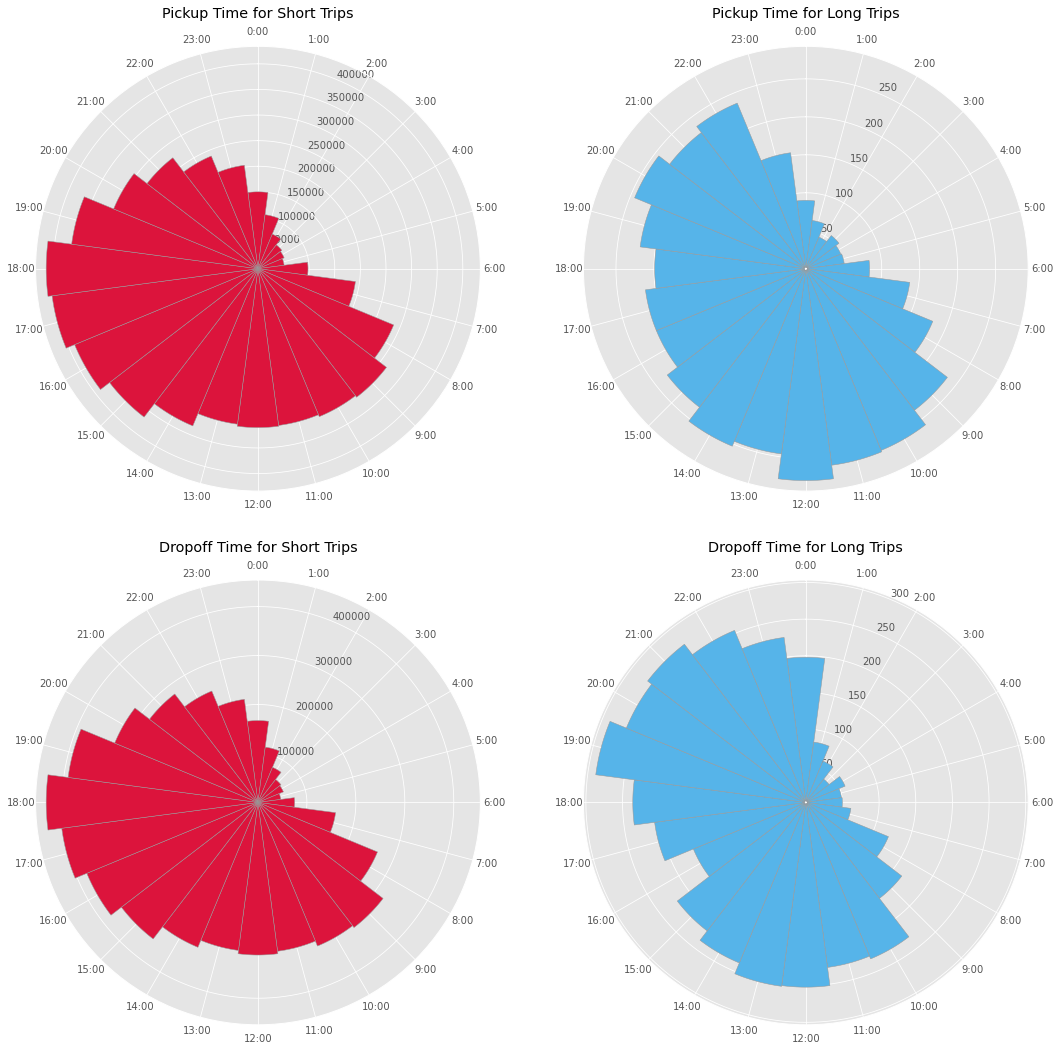

In [55]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})

df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")

diff_short_long_trip_on_time()

In [56]:
df_q3_short = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)
df_q3_long = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)

In [58]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PULocationID", "DOLocationID"], suffixes=["_short", "_long"]).rename(columns={"count_short":"short trips", "count_long":"long trips"})
df_q3 = df_q3.merge(df_loc[["LocationID", "zone"]], left_on="PULocationID", right_on="LocationID").drop(['LocationID'], axis=1).rename(columns={"zone":"pickup zone"}).merge(df_loc[["LocationID", "zone"]], left_on="DOLocationID", right_on="LocationID").drop(['LocationID'], axis=1).rename(columns={"zone":"dropoff zone"})

In [59]:
df_q3

,PULocationID,DOLocationID,short trips,long trips,pickup zone,dropoff zone
0,3,55,4,5,Allerton/Pelham Gardens,Coney Island
1,14,55,363,2,Bay Ridge,Coney Island
2,17,55,152,2,Bedford,Coney Island
3,20,55,1,4,Belmont,Coney Island
4,25,55,291,1,Boerum Hill,Coney Island
...,...,...,...,...,...,...
1257,244,245,1,1,Washington Heights South,West Brighton
1258,245,245,9,2,West Brighton,West Brighton
1259,254,245,1,1,Williamsbridge/Olinville,West Brighton
1260,254,106,5,1,Williamsbridge/Olinville,Gowanus


In [60]:
LongTrip_top3 = df_q3.sort_values(by="long trips", ascending=False).head(3)
LongTrip_top3[['pickup zone', 'dropoff zone', 'long trips']]

,pickup zone,dropoff zone,long trips
358,Brighton Beach,Eastchester,165
1037,Flatbush/Ditmas Park,Jackson Heights,33
233,Jackson Heights,Flatbush/Ditmas Park,31


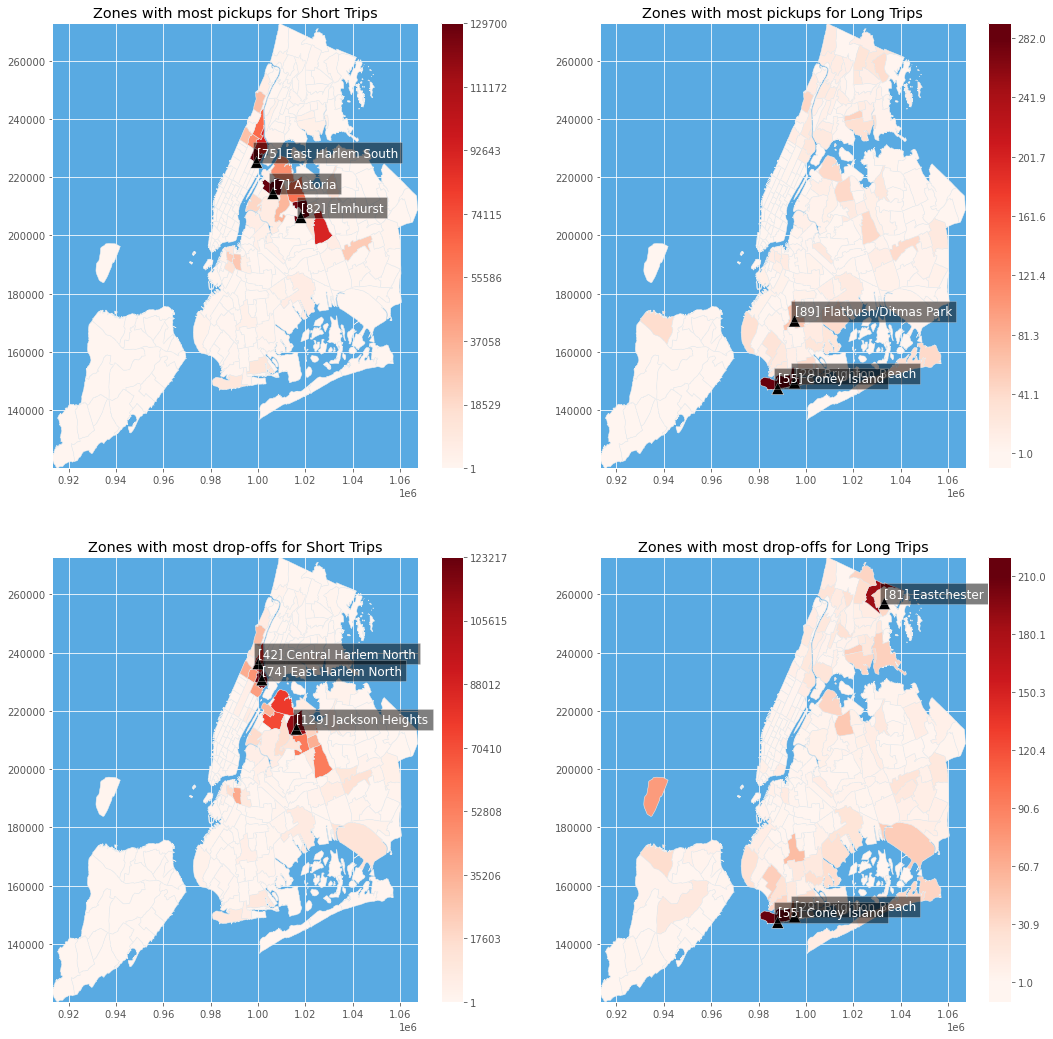

In [61]:
df_q3_PU = df_q3.groupby("PULocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
PUtop3_short = df_q3_PU.sort_values(by=['short trips'], ascending=False).set_index("PULocationID").head(3)
PUtop3_long = df_q3_PU.sort_values(by=['long trips'], ascending=False).set_index("PULocationID").head(3)
PUcount_short = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['short trips'].tolist()))
PUcount_long = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['long trips'].tolist()))

df_q3_DO = df_q3.groupby("DOLocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
DOtop3_short = df_q3_DO.sort_values(by=['short trips'], ascending=False).set_index("DOLocationID").head(3)
DOtop3_long = df_q3_DO.sort_values(by=['long trips'], ascending=False).set_index("DOLocationID").head(3)
DOcount_short = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['short trips'].tolist()))
DOcount_long = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['long trips'].tolist()))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, sf, heat=PUcount_short, text=PUtop3_short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, sf, heat=PUcount_long, text=PUtop3_long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, sf, heat=DOcount_short, text=DOtop3_short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, sf, heat=DOcount_long, text=DOtop3_long.index.tolist())

In [63]:
def diff_short_long_trip_on(attr, rpr="count", kind='bar'):
    df_q3_short = pd.read_sql_query('SELECT '+attr+', count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance < 30 \
                                    GROUP BY '+attr, nyc_database)
    df_q3_long = pd.read_sql_query('SELECT '+attr+', avg(trip_distance) AS AVG_trip_distance, count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance >= 30 \
                                    GROUP BY '+attr, nyc_database)
    if rpr == "proportion":
        s = np.sum(df_q3_short['count'].values)
        df_q3_short['proportion'] = [float(x)/s for x in df_q3_short['count']]
        s = np.sum(df_q3_long['count'].values)
        df_q3_long['proportion'] = [float(x)/s for x in df_q3_long['count']]
    
    df_q3 = df_q3_short.merge(df_q3_long, on=attr, suffixes=["_short", "_long"]) \
                        .rename(columns={rpr+"_short":"short trips", rpr+"_long":"long trips"}) 
    ax = df_q3.plot(x=attr, y=['short trips', 'long trips'], kind=kind, figsize=(15,5))
    ax.set_ylabel(rpr)
    ax.set_title(attr.replace("_", " ")+" difference in short/long trip")

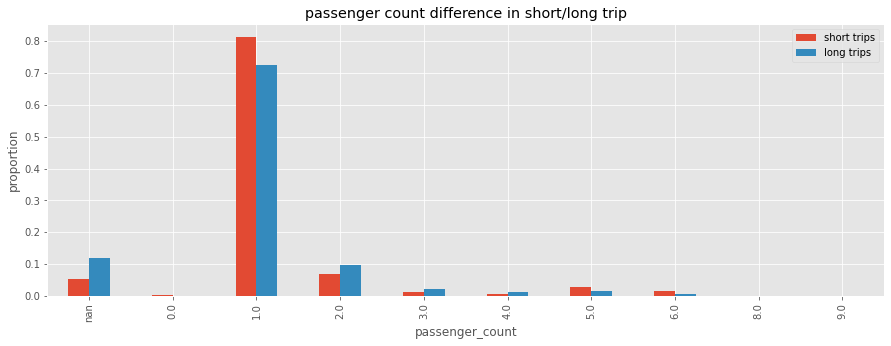

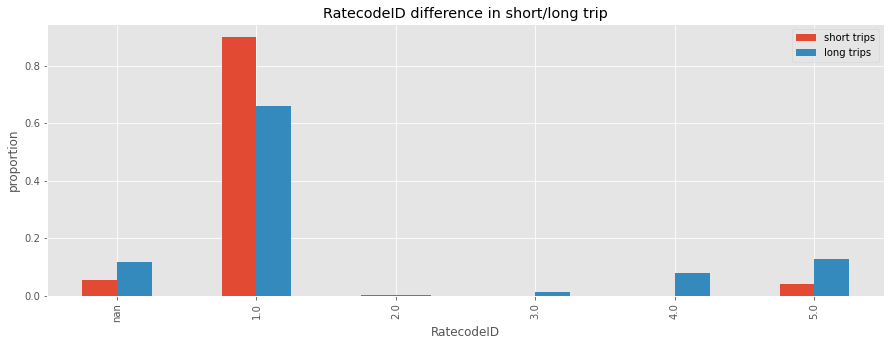

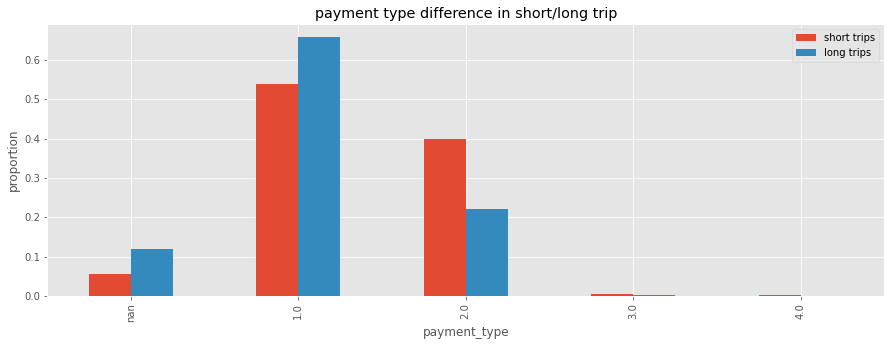

In [64]:
for attr in ["passenger_count", "RatecodeID", "payment_type"]:
    diff_short_long_trip_on(attr, rpr="proportion", kind='bar')